# This is your playground! Leaderboard

 **이번 과제 루브릭**

---



* 캐글 데이터분석 전과정이 성공적으로 진행되었는가?

* 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가? (제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.)

* 회귀모델 예측정확도가 기준 이상 높게 나왔는가? (다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.)


In [1]:
#모듈 세팅
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb #1.
import lightgbm as lgb #2.
import missingno as msno #3.

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

**주요 기능**
---
1.   ***xgboost*** -> Boosting(= ensemble)을 병렬 학습이 지원되도록 구현한 라이브러리다. Regression, Classification 문제를 모두 지원한다. 성능과 자원 효율이 좋다.

2.   ***lightgbm*** -> lightgbm은 Gradient Boosting 프레임워크로 Tree기반 학습 알고리즘을 가진 라이브러리다. 학습이 진행될수록 각 학습당 가지를 쳐내려가는 모양새로 진행이 된다.

3.   ***missingno*** ->missingno는 결측데이터들을 파악하는데 직관적인 도움을 주는 패키지이다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = '/content/drive/MyDrive/kaggledata'

In [4]:
train_data_path = join(data, 'train.csv')
sub_data_path = join(data, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/kaggledata/train.csv
/content/drive/MyDrive/kaggledata/test.csv


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


*  id는 필요가 없는 column
*  date값은 정수로 바꿔줄 필요가 있어 보인다.
*  target이 될 값은 price.

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형으로 전처리
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
y = train['price'] #y축을 target인 price로 설정
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id'] #id삭제

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int) #test도 train과 같이 전처리
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

*  y축으로 price값이 들어간 것을 확인

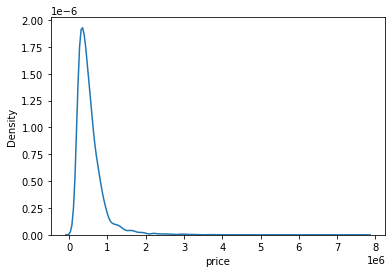

In [11]:
sns.kdeplot(y)
plt.show()

*  데이터가 y축으로 치우쳐져 있다. 데이터를 로그함수처리 해서 분포를 중앙으로 해야 된다.

In [12]:
y = np.log1p(y) #log(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

*  로그함수 처리 된 것을 확인

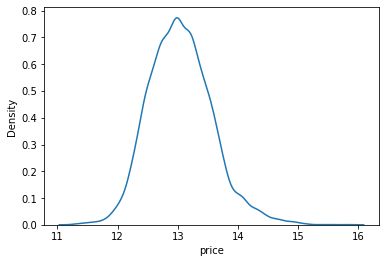

In [13]:
sns.kdeplot(y) #로그정규분포 처리가 된 것을 그래프로 확인 가능하다.
plt.show()

In [14]:
train.info() #정수형자료로 바뀌었는지 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [15]:
#학습모듈
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
#지금 다루는 것이 회귀모델이기 때문에 각 회귀모듈을 불러왔다.

*  Average Blending을 위해서 4가지의 모델을 가져왔다.

In [17]:
#대회 평가 척도인 RMSE를 계산하는 함수

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
random_state=2022 #고정값 지정 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm]

In [19]:
def get_scores(models, train, y): #각 블렌딩의 score를 데이터 프레임 작업
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

[13:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,132088.019304
GradientBoostingRegressor,130361.233685
LGBMRegressor,120099.067237


*  rmse점수가 제일 낮은 LGBM회귀모델을 채용

In [20]:
#모델 최적의 하이퍼 파라미터를 찾는 함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',\
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [21]:
from sklearn.model_selection import GridSearchCV #sklearn의 그리드 서치 모듈

param_grid = param_grid = {'n_estimators': [10, 40, 70, 100],'max_depth': [2, 3, 4, 6, 7], 'num_leaves' : [4, 8, 16, 64, 128],'learning_rate' : [0.001, 0.01]}

*사용된 튜닝 클래스인자*
---
*  **param_grid** : 복수 파라미터 최적화용 그리드
*  **n_estimators** : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
*  **max_depth** : 의사 결정 나무의 깊이, 정수 사용의사 결정 나무의 깊이, 정수 사용
> num_leaves, min_data_in_leaf는 max_depth를 좀더 다양하게 사용하는 인자가 있다.(이번에 여러번 사용해 봤지만 점수가 점점 올라가기만 해서 따로 사용을 하지 않았다.)




In [22]:
model = LGBMRegressor(random_state=random_state) # 위에서 선정한 LGBM회귀모델

In [23]:
grid_model = GridSearchCV(model, param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=5, verbose=1, n_jobs=-1)#n_jobs가 -1 이면 모든 cpu를 가져다가 쓸 수 있다.

grid_model.fit(train, y)
#그리드 서치를 시작

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01],
                         'max_depth': [2, 3, 4, 6, 7],
                         'n_estimators': [10, 40, 70, 100],
                         'num_leaves': [4, 8, 16, 64, 128]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
grid_model.cv_results_ #위에서 실행한 그리드 서치의 결과들

{'mean_fit_time': array([0.0703197 , 0.06757145, 0.07086143, 0.07002482, 0.06923652,
        0.10538201, 0.11032457, 0.10252929, 0.10471997, 0.10784349,
        0.15001173, 0.14771557, 0.15464978, 0.15840645, 0.15198531,
        0.19272714, 0.20005279, 0.20076942, 0.19697752, 0.19208765,
        0.06878648, 0.08016791, 0.07488337, 0.07318778, 0.07619319,
        0.12969847, 0.13742318, 0.13724022, 0.14287019, 0.13820271,
        0.17791457, 0.20737252, 0.20330911, 0.20657825, 0.2080574 ,
        0.23177676, 0.27689376, 0.26326122, 0.26663318, 0.26729708,
        0.06796741, 0.08097963, 0.08855104, 0.08405457, 0.08546004,
        0.12822185, 0.17009797, 0.17775178, 0.18179812, 0.18175602,
        0.18095579, 0.25201263, 0.27735705, 0.28082957, 0.28720655,
        0.23670859, 0.35466628, 0.60534205, 0.5536643 , 0.37801547,
        0.06825929, 0.0836606 , 0.09717779, 0.12308841, 0.12523675,
        0.12815199, 0.16560168, 0.23716636, 0.33425541, 0.34443974,
        0.18410096, 0.257798  ,

In [25]:
params = grid_model.cv_results_['params'] #튜닝한 파라미터의 동작을 확인
params

[{'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 10, 'num_leaves': 4},
 {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 10, 'num_leaves': 8},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 10,
  'num_leaves': 16},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 10,
  'num_leaves': 64},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 10,
  'num_leaves': 128},
 {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 40, 'num_leaves': 4},
 {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 40, 'num_leaves': 8},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 40,
  'num_leaves': 16},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 40,
  'num_leaves': 64},
 {'learning_rate': 0.001,
  'max_depth': 2,
  'n_estimators': 40,
  'num_leaves': 128},
 {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 70, 'num_leaves': 4},
 {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 70, 'num_leaves': 

In [26]:
score = grid_model.cv_results_['mean_test_score'] #점수를 확인

In [27]:
results = pd.DataFrame(params) #mse 점수를 확인
results['score'] = score

results

,learning_rate,max_depth,n_estimators,num_leaves,score
0,0.001,2,10,4,-0.275549
1,0.001,2,10,8,-0.275549
2,0.001,2,10,16,-0.275549
3,0.001,2,10,64,-0.275549
4,0.001,2,10,128,-0.275549
...,...,...,...,...,...
195,0.010,7,100,4,-0.122687
196,0.010,7,100,8,-0.100834
197,0.010,7,100,16,-0.088696
198,0.010,7,100,64,-0.075861


*  조건이 RMSE값을 기준으로 하기에 score에 RMSE를 적용

In [28]:
results['RMSE'] = np.sqrt(-1 * results['score']) 
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSE
0,0.001,2,10,4,-0.275549,0.524927
1,0.001,2,10,8,-0.275549,0.524927
2,0.001,2,10,16,-0.275549,0.524927
3,0.001,2,10,64,-0.275549,0.524927
4,0.001,2,10,128,-0.275549,0.524927
...,...,...,...,...,...,...
195,0.010,7,100,4,-0.122687,0.350267
196,0.010,7,100,8,-0.100834,0.317544
197,0.010,7,100,16,-0.088696,0.297819
198,0.010,7,100,64,-0.075861,0.275428


In [29]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,0.001,2,10,4,-0.275549,0.524927
1,0.001,2,10,8,-0.275549,0.524927
2,0.001,2,10,16,-0.275549,0.524927
3,0.001,2,10,64,-0.275549,0.524927
4,0.001,2,10,128,-0.275549,0.524927
...,...,...,...,...,...,...
195,0.010,7,100,4,-0.122687,0.350267
196,0.010,7,100,8,-0.100834,0.317544
197,0.010,7,100,16,-0.088696,0.297819
198,0.010,7,100,64,-0.075861,0.275428


In [30]:
results = results.sort_values('RMSLE') #sort_values 낮은순서대로 정렬
results

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
199,0.010,7,100,128,-0.074752,0.273408
198,0.010,7,100,64,-0.075861,0.275428
178,0.010,6,100,64,-0.078275,0.279776
179,0.010,6,100,128,-0.078275,0.279776
197,0.010,7,100,16,-0.088696,0.297819
...,...,...,...,...,...,...
4,0.001,2,10,128,-0.275549,0.524927
3,0.001,2,10,64,-0.275549,0.524927
2,0.001,2,10,16,-0.275549,0.524927
1,0.001,2,10,8,-0.275549,0.524927


*  모델 데이터 최소값이 0.273408으로 나온 것을 알 수 있다.

In [31]:
model = LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.01, num_leaves=128, random_state=random_state) #LGBM 학습모델
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.08013597, 13.04676174, 13.72403876, ..., 12.99018859,
       12.90085146, 13.04140985])

In [32]:
prediction = np.expm1(prediction)
prediction

array([479324.87490219, 463591.74412174, 912586.05569811, ...,
       438092.91817823, 400652.18488066, 461117.27408686])

In [33]:
submission_path = join(data, 'sample_submission.csv') #제출용 양식 sample_submission.csv파일을 불러온다
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
submission['price'] = prediction #예측 모델을 sample_submission로 저장
submission.head()

,id,price
0,15035,479324.874902
1,15036,463591.744122
2,15037,912586.055698
3,15038,358207.460593
4,15039,361170.646672


In [35]:
def save_submission(model, train, y, test, model_name):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data = '/content/drive/MyDrive/kaggledata'
    submission_path = join(data, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE.csv'.format(data, model_name)
    submission.to_csv(submission_csv_path, index=False)
    print(format(submission_csv_path))

In [36]:
save_submission(model, train, y, test, 'lgbm')

/content/drive/MyDrive/kaggledata/submission_lgbm_RMSLE.csv


*  예측모델이 문제 없이 작동을 하였다.
*  저장은 구글드라이브로 설정하고 submission 파일을 저장

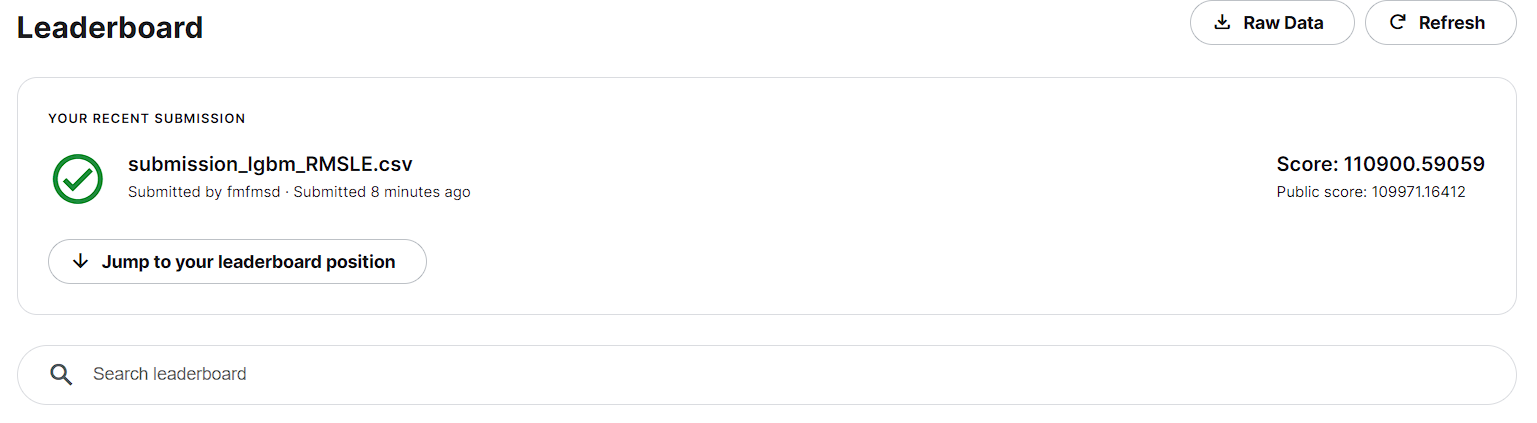

# **마치며**

---

초반엔 최적의 파라미터를 어떻게 설정하는지 감이 잡히질 않아서 스코어가 18~24만 범위로만 나왔다. 수십번의 시행 착오 끝에 가장 알맞은 그리드 모델을 찾아서 다시 튜닝을 하였지만, 결국 110,000점 이하로는 내리지 못하였다.완벽하게 과제를 해낸 것은 아니지만, 지난 일주일동안 캐글을 붙잡고 있으면서 대략적인 앙상블 기법의 메커니즘을 익힐 수 있었다. 나중에 아이펠 후반부쯤 더 많은 지식을 가진 상태에서 다시 한번 이 주제에 대해서 한번 더 도전 해보고 싶다는 생각을 마지막으로 이번 EX3를 마무리 짓는다.

---
추가적으로 제출하는 당일 우재님께서 앙상블 코드
```
# xgboost = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=900, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.019, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.019, max_depth=5, n_estimators=1900, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.019, max_depth=9, n_estimators=1600, random_state=random_state)
ereg = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])
```
sklearn.ensemble의 VotingRegressor을 사용하여 110,000점 아래로 낮추는 것을 성공했다. 일단 내가 만든 코드로 한 것이 아니기 때문에 제출용과제로는 사용하지 않았다. 앙상블에 어느정도 이해 했다고 생각했지만, 내가 한 방법은 굉장히 단순하고 무식하게 하나하나 짚어 가는 것이었다. 하지만 정답에 가까운 값이 되기 위해서 블렌딩을 블렌딩하여 학습률을 높일 수 있다는 것을 알게 되었다.